In [1]:
!pip install ucimlrepo
!pip install xgboost
!pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**1. Procesamiento de Datos:**

In [3]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [4]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [5]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [6]:
 #Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [7]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [8]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

**Modelo Ensamble LIGTHGBM**

In [9]:
#Creación de features basadas en el índice tiempo para captar las estacionalidades

def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour #almacena en una columna nueva la hora
    df['dayofweek'] = df.index.dayofweek #almacena en una columna nueva el día de la semana
    df['month'] = df.index.month #mes
    df['year'] = df.index.year #año

    return df

In [10]:
df = create_features(df)
print(df.head(5))

                     C6H6     T    RH  hour  dayofweek  month  year
Datetime                                                           
2004-03-10 18:00:00  11.9  13.6  48.9    18          2      3  2004
2004-03-10 19:00:00   9.4  13.3  47.7    19          2      3  2004
2004-03-10 20:00:00   9.0  11.9  54.0    20          2      3  2004
2004-03-10 21:00:00   9.2  11.0  60.0    21          2      3  2004
2004-03-10 22:00:00   6.5  11.2  59.6    22          2      3  2004


In [11]:
#Agregado de lags ayuda a captar la estacionaliad
def add_lags(df):
    df['lag_24'] = df['T'].shift(24) #estacionalidad de 1 día
    df['lag_168'] = df['T'].shift(168) #estacionaliad de 1 semana
    df['lag_720'] = df['T'].shift(720) #estacionalidad de 1 mes
    return df

# Aplicar la función al DataFrame
df = add_lags(df)
print(df.tail(5))

                     C6H6     T    RH  hour  dayofweek  month  year  lag_24  \
Datetime                                                                      
2005-04-04 10:00:00  13.5  21.9  29.3    10          0      4  2005    21.1   
2005-04-04 11:00:00  11.4  24.3  23.7    11          0      4  2005    24.0   
2005-04-04 12:00:00  12.4  26.9  18.3    12          0      4  2005    26.5   
2005-04-04 13:00:00   9.5  28.3  13.5    13          0      4  2005    28.7   
2005-04-04 14:00:00  11.9  28.5  13.1    14          0      4  2005    28.5   

                     lag_168  lag_720  
Datetime                               
2005-04-04 10:00:00     17.8     10.0  
2005-04-04 11:00:00     20.8     13.0  
2005-04-04 12:00:00     21.6     14.0  
2005-04-04 13:00:00     23.1     13.3  
2005-04-04 14:00:00     23.6     13.4  


In [12]:
# Eliminar filas con valores NaN (que aparecen debido a los rezagos)
df = df.dropna()

In [13]:
# Seleccionar características y target
features = [col for col in df.columns if col != 'T']
X = df[features]
y = df['T']

In [14]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# Crear el dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [16]:
# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,             # número máximo de hojas que puede tener una sola árbol en el modelo. Un valor mayor permite que el modelo capture más complejidad
    'feature_fraction': 0.9,      # fracción de features que se utilizarán en cada iteración del modelo: un 90% de las características se seleccionarán de forma aleatoria en cada iteración para construir cada árbol
    'bagging_fraction': 0.8,      # fracción de datos que se utilizarán para entrenar cada árbol en lugar de utilizar todos los datos disponibles
    'bagging_freq': 5,            # frecuencia con la que se realizará el bagging (submuestreo) de los datos: 5 significa que el bagging se realizará cada 5 iteraciones del modelo
    'verbose': 0
}

In [17]:
# Entrenar el modelo
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)
model.save_model('lightgbm_model.txt') # para guardar el modelo en un archivo

In [18]:
# Realizar predicciones
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

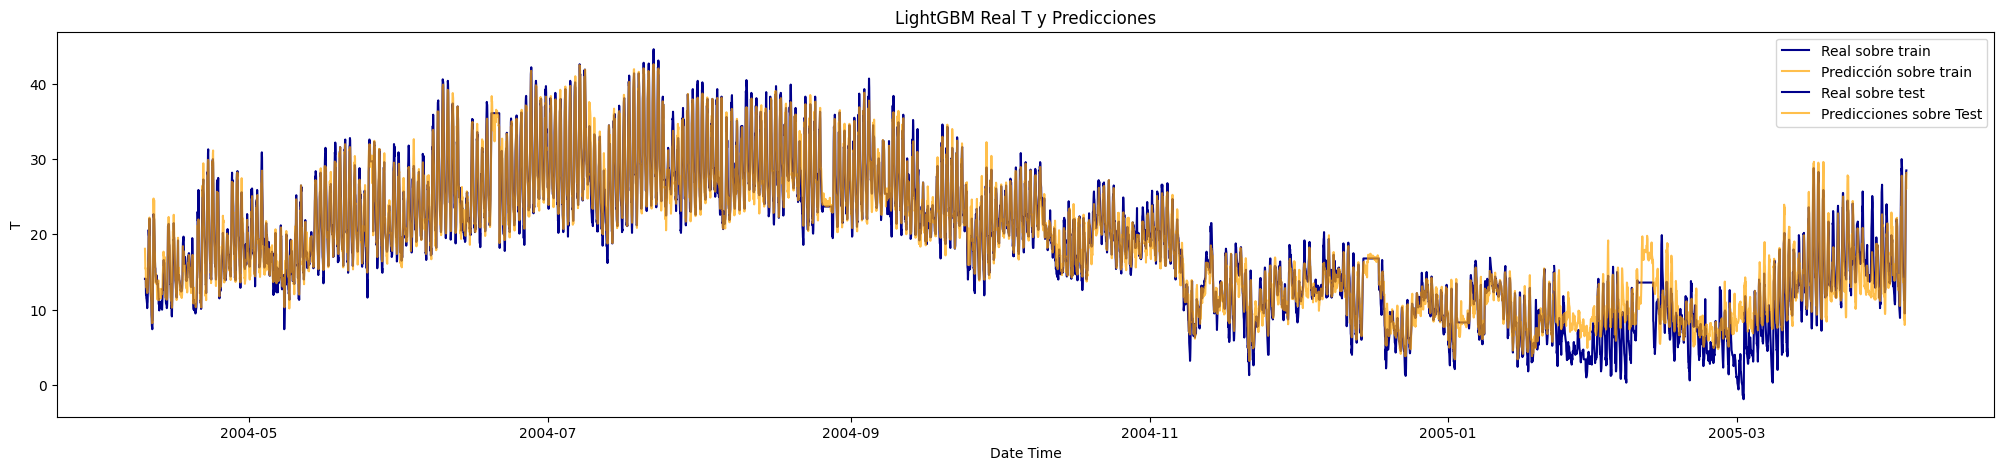

In [19]:
# Graficar los resultados de la serie completa
plt.figure(figsize=(25, 5))
plt.plot(y_train.index, y_train, label='Real sobre train ', color = 'darkblue')
plt.plot(y_train.index, y_pred_train, label='Predicción sobre train', color='orange', alpha=0.7)
plt.plot(y_test.index, y_test, label='Real sobre test', color='darkblue')
plt.plot(y_test.index, y_pred_test, label='Predicciones sobre Test', color='orange', alpha=0.7)
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')
plt.title('LightGBM Real T y Predicciones')
plt.show()

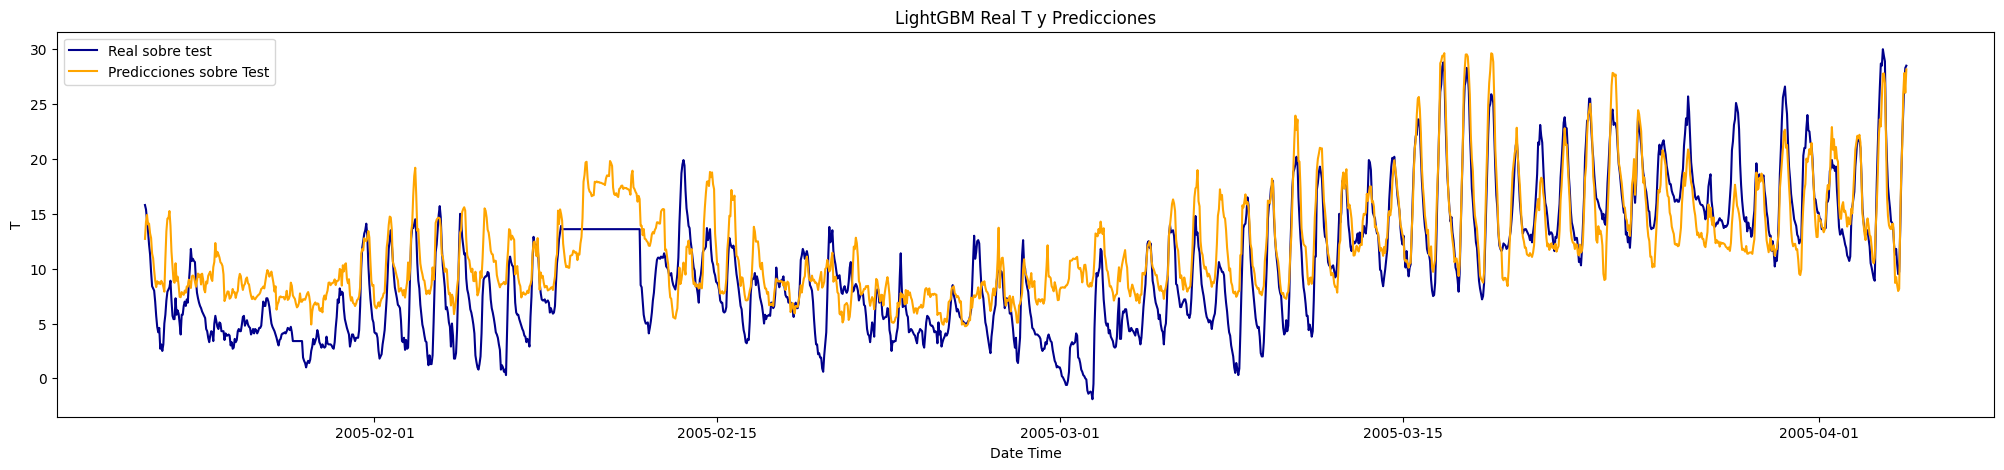

In [20]:
# Graficar los resultados sobre test
plt.figure(figsize=(25, 5))
plt.plot(y_test.index, y_test, label='Real sobre test', color='darkblue')
plt.plot(y_test.index, y_pred_test, label='Predicciones sobre Test', color='orange')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')
plt.title('LightGBM Real T y Predicciones')
plt.show()

In [21]:
# Métriccas
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 12.228326862917518
Mean Absolute Error (MAE): 2.8731440759207487
Root Mean Squared Error (RMSE): 3.49690246688659


***Modelo 2***

Se prueba otro modelo aumentando el numero de hojas.

In [ ]:
# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 70,             # número máximo de hojas que puede tener una sola árbol en el modelo. Un valor mayor permite que el modelo capture más complejidad
    'feature_fraction': 0.9,      # fracción de features que se utilizarán en cada iteración del modelo: un 90% de las características se seleccionarán de forma aleatoria en cada iteración para construir cada árbol
    'bagging_fraction': 0.8,      # fracción de datos que se utilizarán para entrenar cada árbol en lugar de utilizar todos los datos disponibles
    'bagging_freq': 5,            # frecuencia con la que se realizará el bagging (submuestreo) de los datos: 5 significa que el bagging se realizará cada 5 iteraciones del modelo
    'verbose': 0
}

# Entrenar el modelo
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)

# Realizar predicciones
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
# Métriccas
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 13.981023530797058
Mean Absolute Error (MAE): 3.0831991647823336
Root Mean Squared Error (RMSE): 3.739120689520072


No mejoro el modelo aumnetando la cantidad de hojas.

*Modelo 3:*

Se modifica el parametro bagging_freq=15 del Modelo 1.

In [ ]:
# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,             # número máximo de hojas que puede tener una sola árbol en el modelo. Un valor mayor permite que el modelo capture más complejidad
    'feature_fraction': 0.9,      # fracción de features que se utilizarán en cada iteración del modelo: un 90% de las características se seleccionarán de forma aleatoria en cada iteración para construir cada árbol
    'bagging_fraction': 0.8,      # fracción de datos que se utilizarán para entrenar cada árbol en lugar de utilizar todos los datos disponibles
    'bagging_freq': 15,            # frecuencia con la que se realizará el bagging (submuestreo) de los datos: 5 significa que el bagging se realizará cada 5 iteraciones del modelo
    'verbose': 0
}

# Entrenar el modelo
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)

# Realizar predicciones
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
# Métriccas
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 12.595310325528724
Mean Absolute Error (MAE): 2.9057403137106013
Root Mean Squared Error (RMSE): 3.548987225326223


Tampoco se demuestra ninguna mejoria importante.

*Modelo 4:*

En esta ocasion se modifica el parametro learning_rate=0.05

In [ ]:
# Parámetros del modelo LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,             # número máximo de hojas que puede tener una sola árbol en el modelo. Un valor mayor permite que el modelo capture más complejidad
    'feature_fraction': 0.9,      # fracción de features que se utilizarán en cada iteración del modelo: un 90% de las características se seleccionarán de forma aleatoria en cada iteración para construir cada árbol
    'bagging_fraction': 0.8,      # fracción de datos que se utilizarán para entrenar cada árbol en lugar de utilizar todos los datos disponibles
    'bagging_freq': 5,            # frecuencia con la que se realizará el bagging (submuestreo) de los datos: 5 significa que el bagging se realizará cada 5 iteraciones del modelo
    'verbose': 0
}

# Entrenar el modelo
model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=1000)

# Realizar predicciones
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
# Métriccas
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 15.193332042394992
Mean Absolute Error (MAE): 3.203381324460636
Root Mean Squared Error (RMSE): 3.8978624965992568


De los 4 modelos probados, nos quedamos con el Modelo 1 (ya que logro las mejores metricas de performance).

**Pronosticar las proximas 24 horas**

In [22]:
# Último índice en tus datos
last_index = pd.Timestamp('2005-04-04 14:00:00')

In [23]:
# Data frame vacio con el index para los datos futuros
future_dates = pd.date_range(start=last_index + pd.Timedelta(hours=1), periods=24, freq='H')

In [24]:
future_df = pd.DataFrame(index=future_dates)

In [25]:
C6H6_futuro = df['C6H6'].mean()
print(C6H6_futuro)

10.208440430705105


In [26]:
RH_futuro = df['RH'].mean()
print(RH_futuro)

48.7169040175987


In [27]:
#Agregar variables al data frame futuro de 24 horas, simular los lags futuros y estimar un valor  futuro para las variables exógenas

future_df['year'] = future_df.index.year
future_df['month'] = future_df.index.month
future_df['dayofweek'] = future_df.index.dayofweek
future_df['hour'] = future_df.index.hour

future_df['C6H6'] = 10  # Asignar un valor para T (promedio de los valores reales de T)
future_df['RH'] = 48 # Asignar un valor para RH (promedio de los valores reales de RH)
future_df['lag_24'] = future_df['C6H6']  # Simular valores para lag_24
future_df['lag_168'] = future_df['C6H6']  # Simular valores para lag_168
future_df['lag_720'] = future_df['C6H6']  # Simular valores para lag_720

In [28]:
# Ordenar las columnas para que coincidan con las que espera el modelo
feature_columns = ['hour', 'dayofweek', 'month', 'year', 'C6H6', 'RH', 'lag_24', 'lag_168', 'lag_720']
future_df = future_df[feature_columns]

In [29]:
future_predictions = model.predict(future_df)

In [30]:
future_predictions = model.predict(future_df)
future_df['prediction'] = future_predictions
future_df

,hour,dayofweek,month,year,C6H6,RH,lag_24,lag_168,lag_720,prediction
2005-04-04 15:00:00,15,0,4,2005,10,48,10,10,10,16.805456
2005-04-04 16:00:00,16,0,4,2005,10,48,10,10,10,16.853277
2005-04-04 17:00:00,17,0,4,2005,10,48,10,10,10,16.957663
2005-04-04 18:00:00,18,0,4,2005,10,48,10,10,10,17.024141
2005-04-04 19:00:00,19,0,4,2005,10,48,10,10,10,17.052771
2005-04-04 20:00:00,20,0,4,2005,10,48,10,10,10,17.156083
2005-04-04 21:00:00,21,0,4,2005,10,48,10,10,10,17.156083
2005-04-04 22:00:00,22,0,4,2005,10,48,10,10,10,17.243036
2005-04-04 23:00:00,23,0,4,2005,10,48,10,10,10,17.357662
2005-04-05 00:00:00,0,1,4,2005,10,48,10,10,10,15.025561


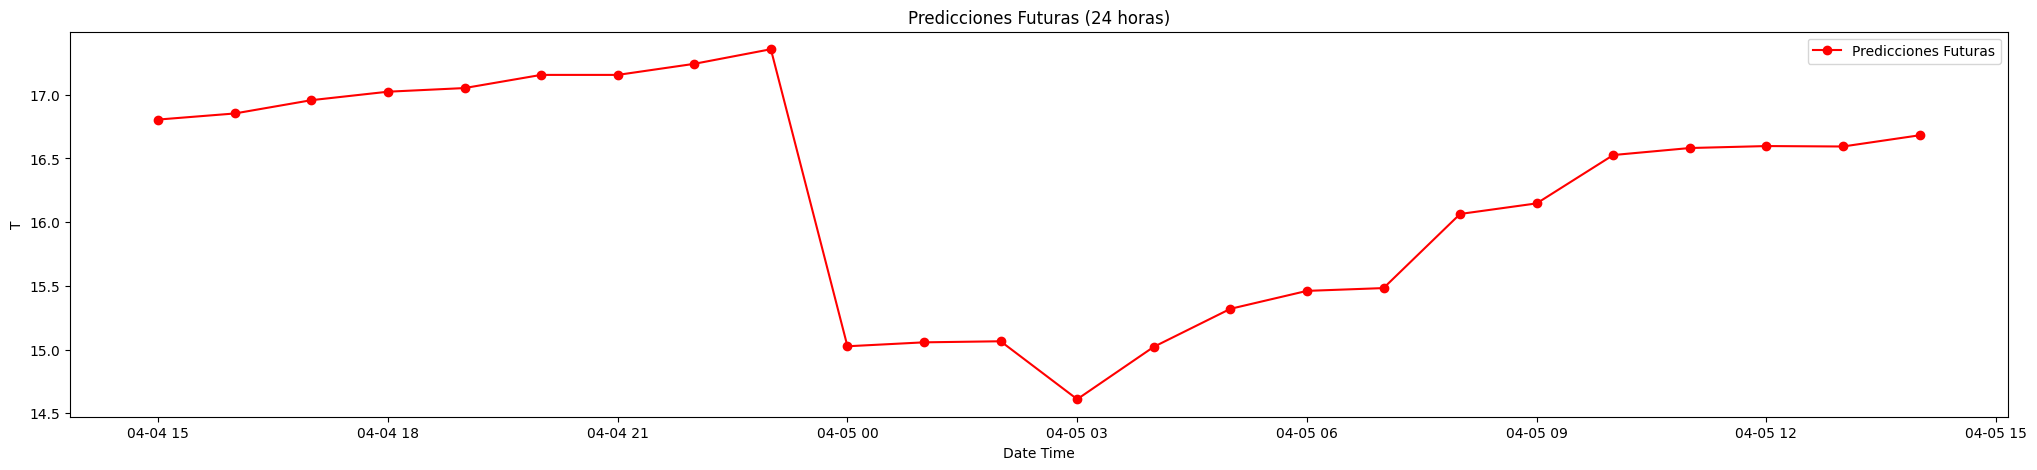

In [31]:
plt.figure(figsize=(25, 5))

# Graficar predicciones futuras
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')

plt.title('Predicciones Futuras (24 horas)')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')

# Mostrar el gráfico
plt.show()

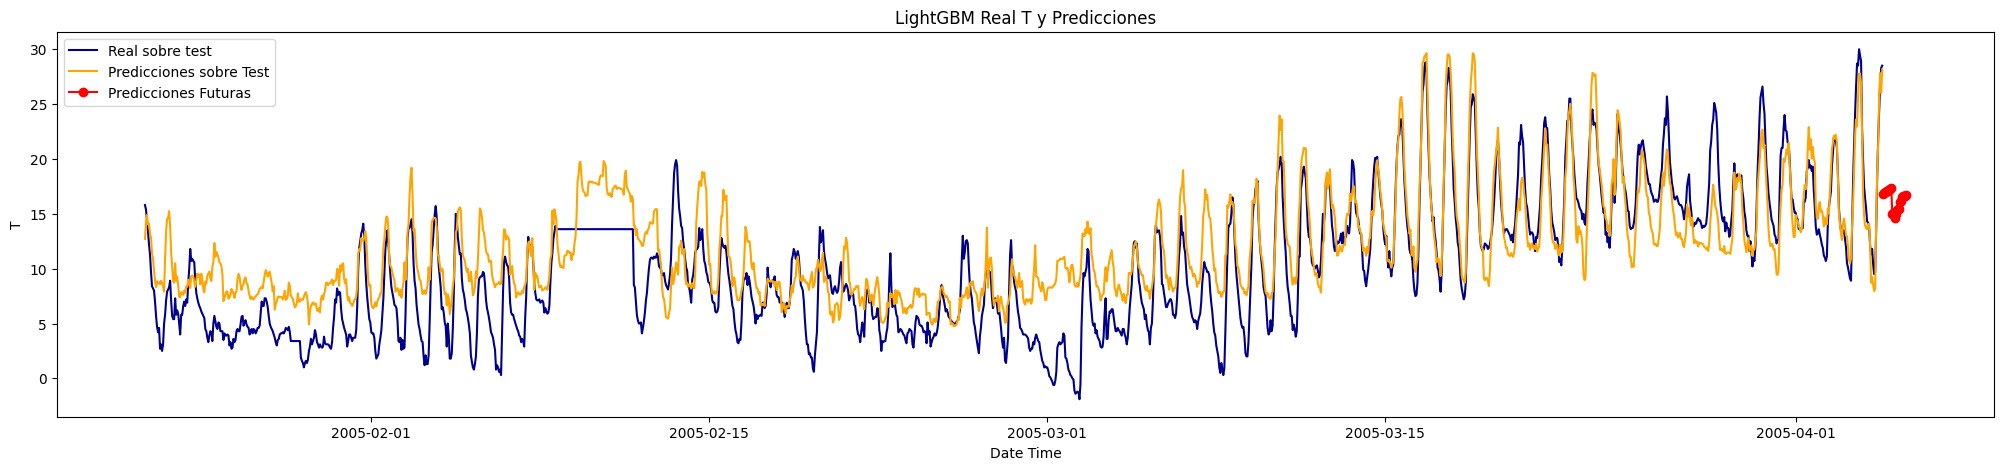

In [32]:
# Graficar los resultados sobre test
plt.figure(figsize=(25, 5))
plt.plot(y_test.index, y_test, label='Real sobre test', color='darkblue')
plt.plot(y_test.index, y_pred_test, label='Predicciones sobre Test', color='orange')
plt.plot(future_df.index, future_df['prediction'], label='Predicciones Futuras',  color='red', marker='o')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('T')
plt.title('LightGBM Real T y Predicciones')
plt.show()